## Machine Learning (Supervised Learning)

### Project: Finding Donors for *CharityML*

## Getting Started

In this project, I have employed several supervised algorithmsto accurately model individuals' income using data collected from the 1994 U.S. Census. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data

In [10]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from __future__ import division #For simple division

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline
# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

age   workclass education_level  education-num  marital-status  \
0   39   State-gov       Bachelors           13.0   Never-married   

      occupation    relationship    race    sex  capital-gain  capital-loss  \
0   Adm-clerical   Not-in-family   White   Male        2174.0           0.0   

   hours-per-week  native-country income  
0            40.0   United-States  <=50K

### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. 

In [ ]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data.income == ">50K"])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data.income == "<=50K"])
# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k*100)/n_records


print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000:{:.2f}%".format(greater_percent)

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

The code cell below plots a histogram of these two features. Note the range of the values present and how they are distributed.

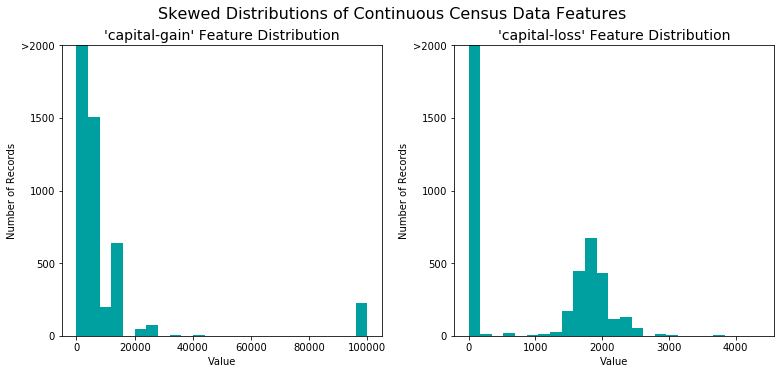

In [12]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

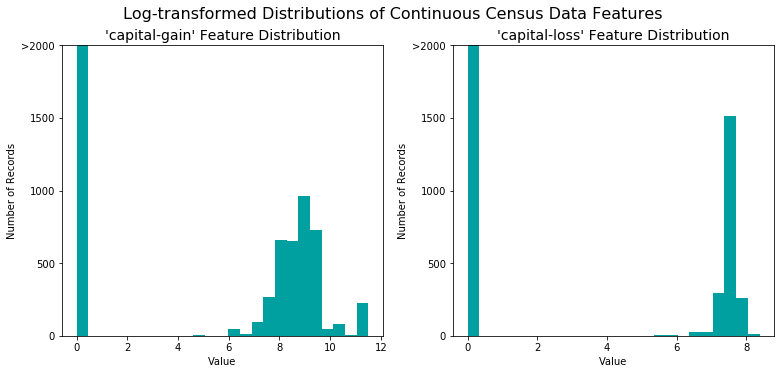

In [13]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [14]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(features_raw[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

age   workclass education_level  education-num  marital-status  \
0  0.30137   State-gov       Bachelors            0.8   Never-married   

      occupation    relationship    race    sex  capital-gain  capital-loss  \
0   Adm-clerical   Not-in-family   White   Male      0.667492           0.0   

   hours-per-week  native-country  
0        0.397959   United-States

### Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.


In [ ]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x == '<=50K' else 1)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [16]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


/Users/nsb/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Naive Predictor Performace


In [17]:

accuracy = (n_greater_50k/n_records)

true_positives = n_greater_50k
true_negatives = 0
false_positives = n_at_most_50k
false_negatives = 0

precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives + false_negatives)
# TODO: Calculate F-score using the formula above for beta = 0.5
fscore = (1 + 0.5**2) * ((precision * recall)/(0.5**2 * (precision * recall) + 1))

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

__I believe KNN, Decison Trees and Gaussian Naive Bayes can be used for finding donors problem. To justify this, I tried to come up with following justification:__

**K-Nearest Neighbours:**

KNN are the supervised learning algorithms that are used in 'Hand-Written Character Classification'.
Advantages of KNN include:
a)Simplicity
b)No training involved and can be used for regression.
Since KNN is a lazy learner and does not assume any probability distribution, so need to load entire training set everytime testing is done, so it works well when there is less training data.
The disadvantage is that this model takes more computation time.
Since, we have less training data but the most important reason why KNN is a good candidate is there is no learning as it loads the entire dataset.

**Decision Trees:**

Decision Trees are used to improve the baseline movie recommendation approach of NETFLIX by 10% in accuracy.
Decision trees have the ability of selecting good features and can deal with noisy data. It works well when there are lot of features and need to select best features.
The disadvantage is that this model tends to overfit.
We can use Decision tree for this problem since it can implicitly do feature selection for us.

**Gaussian Naive Bayes:**

Gaussian Naive Bayes are used to check whether the email is spam or not. 
Gaussian Naive Bayes are easy to implement and works great with big feature space. Suprisingly, it performs well because of it's simplicity though it has the disadvantage that it assumes all the features are independent.
We can try this model for this problem and see for ourselves if it's simplicity can lead to better performance.

Resources: Wikipedia, Quora 

### Creating a Training and Predicting Pipeline

In [ ]:
from sklearn.metrics import fbeta_score, accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    results['train_time'] = end - start
        
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train )
        
    results['acc_test'] = accuracy_score(predictions_test, y_test)
    
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=0)
clf_C = KNeighborsClassifier(3)

samples_1 = int(0.01*len(X_train))
samples_10 = int(0.1*len(X_train))
samples_100 = int(1*len(X_train))

results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

vs.evaluate(results, accuracy, fscore)

### Choosing the Best Model

Form the visualization above, it seems DecisionTreeClassifier does a pretty decent job where as K-Nearest Neighbor also serves the purpose but the accuray and f-score of DecisionTreeClassifier is more and GaussianNB is totally useless for this kind of problem.
The accuracy score and F-score on training data, DecisionTreeClassifier has the highest score but the same scores on testing data, DecisionTreeClassifier performs slightly better than K-NearestNeighbor.

DecisionTreeClassifier takes less time during the training phase whereas the KNN takes longest and GaussianNB takes lowest but the NB's scores are very disappointing.

**Explanation of the Model**

Okay, the final model chosen is DecisionTreeClassifier. A decision tree is an inverted tree with root at the top with nodes on which tree splits into branches. When the node cannot be split further, it's a leaf node. Let's take an example that takes standard titanic dataset to figure out whether a person will survive or not.
<img src="1.png"><br>
This tree classifies whether a person will survive or not. We try with all the features and start with one that gives the best split. A good split is generally that maximizes the difference between the classes. In the example above, survived and died are two classes, we split based on feature that best distinguishes these classes. For the sake of explanation lets take a feature that does not helps in deciding whether the person will survive or not. Let's say did the person have breakfast or not? Either answer to this question 'yes'or 'no' does not point if the person will surive or not and thus leads to a bad split. Therefore, decision tree is build based on features that best splits the data and stops building tree when some stopping criteria is achived.
So, the decision tree splits the data and which feature gives the best split is taken into consideration.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,fbeta_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

parameters = {'max_features': ['auto', 'log2',None],
              'splitter': ['best', 'random'],
             'max_depth': list(range(40, 80))
             }

scorer = make_scorer(fbeta_score,beta=0.5)

grid_obj = GridSearchCV(clf,parameters,scoring=scorer,n_jobs=5)

grid_fit = grid_obj.fit(X_train,y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

### Final Model Evaluation

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      24.78%         |      81.86%       |       83.9% 
|
| F-score        |      29.17%         |      62.79%       |       67.2%     |


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.


### Feature Relevance Observation

According to me following 5 are the most important features out of 13:<br>

1)Education-Level: Level of education decides what role you play in which company. It's a game changer.<br>
2)Naitve Countries: People get high pay check in developed countries. <br>
3)Occupation: Your occupation decides your pay-check <br>
4))Age: Well age is an important factor, more young you are, more productivity you'll bring hopefully.<br>
5)Hours-per-week: More hours mean more money and could be a good feature in guessing the target.<br>


### Implementation - Extracting Feature Importance

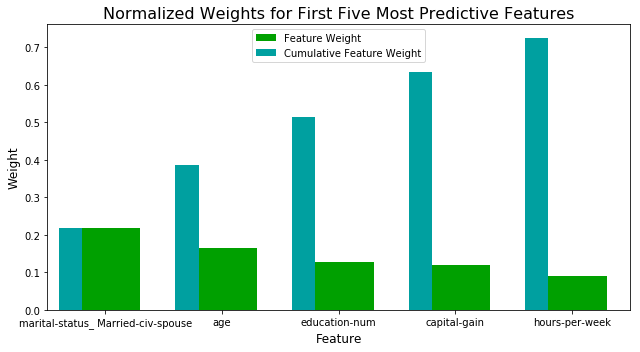

In [42]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier().fit(X_train,y_train)

importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. 

In [43]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8197
F-score on testing data: 0.6302

Final Model trained on reduced data
------
Accuracy on testing data: 0.8302
F-score on testing data: 0.6559


### Effects of Feature Selection



Reducing the number of features has less accuray and f-score probably because the classifier could not train well and therefore didn't generalize enough. But if training time was a factor, we would definatley compromise with the accuracy and f1 score as they are not too different from the optimized model and so will consider reduced data set. 